In [1]:
# ===== 모델 초기화 (Linux NVIDIA GPU) =====
import os

# ⭐ pip CUDA를 시스템 CUDA보다 먼저 사용하도록 PATH 설정
# 시스템 ptxas(12.5)와 pip CUDA(12.9) 버전 충돌 해결
CUDA_NVCC_PATH = "/home/yu_mcc/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/nvidia/cuda_nvcc/bin"
os.environ['PATH'] = CUDA_NVCC_PATH + ":" + os.environ.get('PATH', '')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

print(f"TensorFlow 버전: {tf.__version__}")

# NVIDIA GPU 확인 및 활성화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ NVIDIA GPU 발견: {len(gpus)}개")
    for gpu in gpus:
        print(f"   - {gpu.name}")
    # GPU 메모리 동적 할당 (필요한 만큼만 사용)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU 메모리 동적 할당 활성화됨!")
    except RuntimeError as e:
        print(f"⚠️ 메모리 설정 실패: {e}")
else:
    print("⚠️ GPU가 발견되지 않았습니다. CPU를 사용합니다.")

# GPU 연산 테스트 (에러 발생시 CPU로 폴백)
print("\n=== GPU 연산 테스트 ===")
try:
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
    print(f"✅ GPU 연산 테스트 완료: shape = {c.shape}")
except Exception as e:
    print(f"⚠️ GPU 연산 실패, CPU 사용: {e}")

# Keras 백엔드 초기화
tf.keras.backend.clear_session()
print("\n✅ TensorFlow 및 GPU 초기화 완료")


I0000 00:00:1770021720.007323   11460 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1770021721.747168   11460 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow 버전: 2.21.0-dev20260113
✅ NVIDIA GPU 발견: 1개
   - /physical_device:GPU:0
✅ GPU 메모리 동적 할당 활성화됨!

=== GPU 연산 테스트 ===
✅ GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 GPU 초기화 완료


# 피싱 탐지를 위한 임베딩 모델

이 노트북은 피싱 탐지를 위한 임베딩 모델을 학습합니다.

## 목표
- Autoencoder를 사용하여 피싱 데이터의 저차원 임베딩 생성
- 학습된 임베딩 공간에서 코사인 유사도를 사용한 피싱 탐지
- 정상/피싱 샘플의 프로토타입 벡터 생성 및 저장

## 프레임워크
1. 데이터 로드 및 전처리
2. Autoencoder 모델 학습 (차원 축소)
3. 임베딩 공간에서 정상/피싱 프로토타입 생성
4. 유사도 기반 분류기 테스트
5. 모델 및 프로토타입 저장

In [2]:
# ===== 0) 환경 설정 및 Import =====
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_gpu'

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("TensorFlow 버전:", tf.__version__)
print("NumPy 버전:", np.__version__)
print("Pandas 버전:", pd.__version__)

TensorFlow 버전: 2.21.0-dev20260113
NumPy 버전: 2.2.6
Pandas 버전: 2.3.3


In [3]:
# ===== 1) 설정 =====
# 🔧 Linux 환경 경로
DATA_PATH = "/home/yu_mcc/QR_Phishing/phishing/phishing_data_tflite_ready.csv"
TARGET_COL = "status"
EMBEDDING_DIM = 32  # 임베딩 차원 (원래 설정으로 복원)
BATCH_SIZE = 32  # 배치 크기 (원래 설정으로 복원)
EPOCHS = 200  # 에폭 (원래 설정으로 복원)
LEARNING_RATE = 0.0001  # 로스 폭발 방지: 0.001 → 0.0001
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"설정 완료: 임베딩 차원={EMBEDDING_DIM}, 배치 크기={BATCH_SIZE}, 에폭={EPOCHS}")

설정 완료: 임베딩 차원=32, 배치 크기=32, 에폭=200


In [4]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11481, 65)

컬럼 목록:
['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'shortening_service', 'path_extension', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_extCSS', 'login_form', 'submit_email', 'sfh', 'iframe', 'popup_window', 'onmouseover', 'right_clic', 'empty_title', 'domain_in_title', 'do

In [5]:
# ===== 3) 피처 및 레이블 분리 (50:50 균형 분할) =====
# 원본 데이터 보존을 위해 복사본 사용
df_work = df.copy()

# 'id' 컬럼이 있다면 제거
if 'id' in df_work.columns:
    df_work = df_work.drop(columns=['id'])

# 타겟 변수 그대로 사용
# status: 0 = 정상, 1 = 피싱
# 모델 출력도 동일: 0에 가까우면 정상, 1에 가까우면 피싱

print(f"피처 개수: {len(df_work.columns) - 1}")
print(f"전체 데이터 shape: {df_work.shape}")
print(f"\n원본 레이블 분포:")
print(f"  - 정상(0): {(df_work[TARGET_COL]==0).sum()}")
print(f"  - 피싱(1): {(df_work[TARGET_COL]==1).sum()}")

# ===== 50:50 균형 분할 함수 =====
def split_class(class_df, train_ratio=0.6, val_ratio=0.2, seed=42):
    """클래스별로 train/val/test 분할"""
    # 여러 번 셔플해서 패턴 편향 방지
    shuffled = class_df.sample(frac=1, random_state=seed)
    shuffled = shuffled.sample(frac=1, random_state=seed+1)
    shuffled = shuffled.sample(frac=1, random_state=seed+2)
    
    n = len(shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    return (shuffled.iloc[:train_end], 
            shuffled.iloc[train_end:val_end], 
            shuffled.iloc[val_end:])

# 클래스별로 분리
df_legit = df_work[df_work[TARGET_COL] == 0]  # 정상
df_phish = df_work[df_work[TARGET_COL] == 1]  # 피싱

# 각 클래스별로 60/20/20 분할
legit_train, legit_val, legit_test = split_class(df_legit, seed=RANDOM_SEED)
phish_train, phish_val, phish_test = split_class(df_phish, seed=RANDOM_SEED)

# 합치기 (각 세트에서 50:50 비율 유지)
train_df = pd.concat([legit_train, phish_train]).sample(frac=1, random_state=RANDOM_SEED)
val_df = pd.concat([legit_val, phish_val]).sample(frac=1, random_state=RANDOM_SEED)
test_df = pd.concat([legit_test, phish_test]).sample(frac=1, random_state=RANDOM_SEED)

# 피처와 레이블 분리
X_train = train_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_train = train_df[TARGET_COL].values.astype(np.float32)

X_val = val_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_val = val_df[TARGET_COL].values.astype(np.float32)

X_test = test_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_test = test_df[TARGET_COL].values.astype(np.float32)

# 결과 출력
print(f"\n===== 50:50 균형 분할 결과 =====")
print(f"Train: {X_train.shape} - 정상:{(y_train==0).sum()}, 피싱:{(y_train==1).sum()}")
print(f"Val:   {X_val.shape} - 정상:{(y_val==0).sum()}, 피싱:{(y_val==1).sum()}")
print(f"Test:  {X_test.shape} - 정상:{(y_test==0).sum()}, 피싱:{(y_test==1).sum()}")

# 비율 확인
print(f"\n===== 각 세트의 피싱 비율 =====")
print(f"Train 피싱 비율: {y_train.mean()*100:.1f}%")
print(f"Val 피싱 비율:   {y_val.mean()*100:.1f}%")
print(f"Test 피싱 비율:  {y_test.mean()*100:.1f}%")

피처 개수: 64
전체 데이터 shape: (11481, 65)

원본 레이블 분포:
  - 정상(0): 5740
  - 피싱(1): 5741

===== 50:50 균형 분할 결과 =====
Train: (6888, 64) - 정상:3444, 피싱:3444
Val:   (2296, 64) - 정상:1148, 피싱:1148
Test:  (2297, 64) - 정상:1148, 피싱:1149

===== 각 세트의 피싱 비율 =====
Train 피싱 비율: 50.0%
Val 피싱 비율:   50.0%
Test 피싱 비율:  50.0%


In [6]:
# ===== 4) 데이터 전처리 (RobustScaler만 적용) =====
# ✅ 이상치에 민감한 피처: RobustScaler (중앙값/IQR 기반) - 이상치에 더 강함
# ✅ 나머지 피처: 정규화 없음 (원본 그대로 사용 - 모델이 원래 스케일 직접 학습)
# Android에서는 RobustScaler 파라미터만 사용해 전처리 필요

from sklearn.preprocessing import RobustScaler

# RobustScaler를 적용할 피처 목록 (이상치가 많은 피처들)
# ⚠️ 제거된 피처 (CSV에 없음): nb_redirection, ratio_extRedirection, ratio_extErrors
robust_cols = [
    'length_url',
    'length_hostname',
    'nb_dots',
    'nb_hyphens',
    'nb_and',
    'nb_eq',
    'nb_underscore',
    'nb_percent',
    'nb_slash',
    'nb_colon',
    'nb_semicolumn',
    'nb_space',
    'nb_com',
    'ratio_digits_url',
    'ratio_digits_host',
    'length_words_raw',
    'char_repeat',
    'shortest_words_raw',
    'shortest_word_host',
    'shortest_word_path',
    'longest_words_raw',
    'longest_word_host',
    'longest_word_path',
    'avg_words_raw',
    'avg_word_host',
    'avg_word_path',
    'phish_hints',
    'nb_extCSS',
]

# 피처 인덱스 매핑
feature_names = [col for col in df_work.columns if col != TARGET_COL]
robust_indices = [feature_names.index(col) for col in robust_cols if col in feature_names]
raw_indices = [i for i in range(len(feature_names)) if i not in robust_indices]

print(f"RobustScaler 적용 피처: {len(robust_indices)}개")
print(f"정규화 없음 (원본 그대로): {len(raw_indices)}개")

# RobustScaler 생성
robust_scaler = RobustScaler()

# 스케일링 수행
X_train_scaled = X_train.copy().astype(np.float32)
X_val_scaled = X_val.copy().astype(np.float32)
X_test_scaled = X_test.copy().astype(np.float32)

# RobustScaler 적용만 (중앙값 기반 - 이상치 영향 적음)
X_train_scaled[:, robust_indices] = robust_scaler.fit_transform(X_train[:, robust_indices]).astype(np.float32)
X_val_scaled[:, robust_indices] = robust_scaler.transform(X_val[:, robust_indices]).astype(np.float32)
X_test_scaled[:, robust_indices] = robust_scaler.transform(X_test[:, robust_indices]).astype(np.float32)

# raw_indices는 그대로 두기 (정규화 안 함)

print("\n데이터 전처리 완료 (RobustScaler만 적용)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"Train 피처 평균: {X_train_scaled.mean():.4f}, 표준편차: {X_train_scaled.std():.4f}")
print(f"피처 개수: {X_train_scaled.shape[1]}개")

# Android에서 사용할 파라미터 저장
scaler_params = {
    'type': 'robust_only',
    'robust_cols': robust_cols,
    'robust_center': robust_scaler.center_.tolist(),
    'robust_scale': robust_scaler.scale_.tolist(),
    'raw_cols': [feature_names[i] for i in raw_indices]
}

print(f"\n📊 Scaler 파라미터 (Android 전처리용):")
print(f"   RobustScaler: {len(robust_cols)}개 피처")
print(f"   원본 그대로: {len(raw_indices)}개 피처)")

RobustScaler 적용 피처: 28개
정규화 없음 (원본 그대로): 36개

데이터 전처리 완료 (RobustScaler만 적용)
Train 피처 범위: min=-2.00, max=124.00
Train 피처 평균: 0.2121, 표준편차: 0.9919
피처 개수: 64개

📊 Scaler 파라미터 (Android 전처리용):
   RobustScaler: 28개 피처
   원본 그대로: 36개 피처)


In [7]:
# ===== 5) 분류 모델 구축 (TFLite 친화적: 정규화 레이어 없음) =====
# ✅ Dense + ReLU + L2 regularization만 사용
# ✅ 입력은 RobustScaler만 적용 (40개 피처는 원본 그대로)
keras.backend.clear_session()
gc.collect()

input_dim = X_train_scaled.shape[1]
L2_REG = 0.0005  # 로스 폭발 방지: 0.001 → 0.0001

encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')

# Encoder 블록 (정규화 레이어 없이 L2 regularization만 사용 - Dropout 제거)
# ⭐ TFLite 호환성: Dropout 제거 (TFLite에서 Dropout이 활성화 상태로 남을 수 있음)
x = layers.Dense(256, activation='relu', 
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='encoder_dense1')(encoder_input)

x = layers.Dense(128, activation='relu',
                 kernel_initializer='he_normal', 
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='encoder_dense2')(x)

x = layers.Dense(64, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='encoder_dense3')(x)

# 임베딩 레이어
embedding = layers.Dense(EMBEDDING_DIM, activation='relu', 
                         kernel_regularizer=keras.regularizers.l2(L2_REG),
                         name='embedding')(x)

# Classification Head (Dropout 제거)
x = layers.Dense(32, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='classifier_dense1')(embedding)

x = layers.Dense(16, activation='relu',
                 kernel_regularizer=keras.regularizers.l2(L2_REG),
                 name='classifier_dense2')(x)
output = layers.Dense(1, activation='sigmoid', name='output')(x)

# 전체 분류 모델
classifier = Model(inputs=encoder_input, outputs=output, name='phishing_classifier')

# Encoder만 따로 (임베딩 추출용)
encoder = Model(inputs=encoder_input, outputs=embedding, name='encoder')

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("\n===== 분류 모델 구조 (TFLite 친화적: 정규화 레이어 없음) =====")
print("✅ Dense + ReLU + L2 regularization만 사용")
print("✅ 입력: RobustScaler 31개 피처 + 원본 40개 피처")
classifier.summary()
print("\n===== Encoder 모델 구조 =====")
encoder.summary()


===== 분류 모델 구조 (TFLite 친화적: 정규화 레이어 없음) =====
✅ Dense + ReLU + L2 regularization만 사용
✅ 입력: RobustScaler 31개 피처 + 원본 40개 피처


Model: "phishing_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,473 (240.13 KB)

 Trainable params: 61,473 (240.13 KB)

 Non-trainable params: 0 (0.00 B)


===== Encoder 모델 구조 =====


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,872 (233.88 KB)

 Trainable params: 59,872 (233.88 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ===== 6) 분류 모델 학습 =====
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

history = classifier.fit(
    X_train_scaled, y_train,  # 피처 -> 레이블 (분류 학습)
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n분류 모델 학습 완료!")

Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6626 - auc: 0.8090 - loss: 1.0707 - val_accuracy: 0.8258 - val_auc: 0.9011 - val_loss: 0.9075 - learning_rate: 1.0000e-04
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8545 - auc: 0.9256 - loss: 0.8193 - val_accuracy: 0.8737 - val_auc: 0.9480 - val_loss: 0.7558 - learning_rate: 1.0000e-04
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8830 - auc: 0.9508 - loss: 0.7329 - val_accuracy: 0.8911 - val_auc: 0.9585 - val_loss: 0.7052 - learning_rate: 1.0000e-04
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9001 - auc: 0.9610 - loss: 0.6861 - val_accuracy: 0.8976 - val_auc: 0.9628 - val_loss: 0.6744 - learning_rate: 1.0000e-04
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - auc: 0.9669 - loss: 0.6524 - val_accuracy: 0.9042 - val_auc: 0.9652 - val_loss: 0.6508 - learning_rate: 1.0000e-04
Epoch 6/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

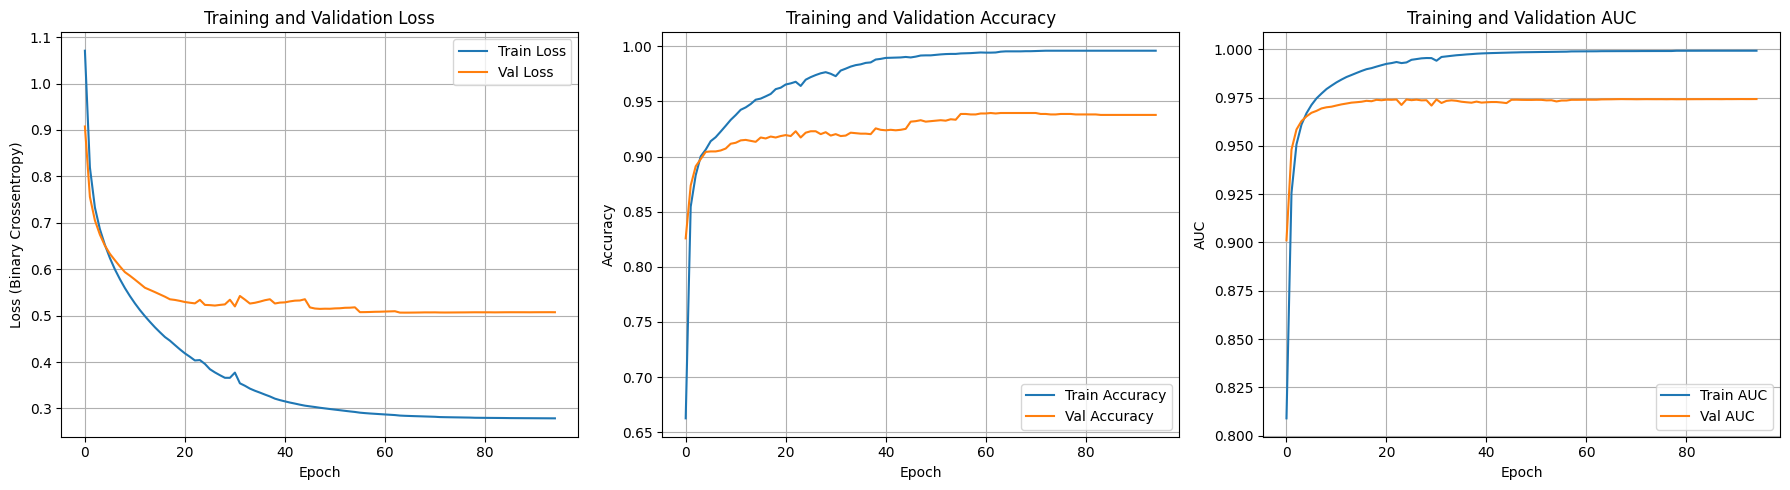

In [9]:
# ===== 7) 학습 곡선 시각화 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Binary Crossentropy)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Training and Validation AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [10]:
# ===== 8) 모델 평가 (Validation) =====
print("="*60)
print("모델 평가 (Validation Set)")
print("="*60)

# 예측
pred_val = classifier.predict(X_val_scaled, verbose=0)
pred_val_proba = pred_val.flatten()
pred_val_binary = (pred_val_proba > 0.5).astype(int)

# 메트릭 계산
val_loss, val_acc, val_auc = classifier.evaluate(X_val_scaled, y_val, verbose=0)
val_precision = precision_score(y_val, pred_val_binary)
val_recall = recall_score(y_val, pred_val_binary)
val_f1 = f1_score(y_val, pred_val_binary)

print(f"\n📊 성능 메트릭:")
print(f"  - Accuracy:  {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"  - Precision: {val_precision:.4f}")
print(f"  - Recall:    {val_recall:.4f}")
print(f"  - F1 Score:  {val_f1:.4f}")
print(f"  - AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 분류 리포트:")
print(classification_report(y_val, pred_val_binary, target_names=['Legitimate', 'Phishing']))

모델 평가 (Validation Set)

📊 성능 메트릭:
  - Accuracy:  0.9395 (93.95%)
  - Precision: 0.9316
  - Recall:    0.9486
  - F1 Score:  0.9400
  - AUC-ROC:   0.9741

📋 분류 리포트:
              precision    recall  f1-score   support

  Legitimate       0.95      0.93      0.94      1148
    Phishing       0.93      0.95      0.94      1148

    accuracy                           0.94      2296
   macro avg       0.94      0.94      0.94      2296
weighted avg       0.94      0.94      0.94      2296



In [11]:
# ===== 9) 모델 평가 (Test) =====
print("="*60)
print("모델 평가 (Test Set)")
print("="*60)

# 예측
pred_test = classifier.predict(X_test_scaled, verbose=0)
pred_test_proba = pred_test.flatten()
pred_test_binary = (pred_test_proba > 0.5).astype(int)

# 메트릭 계산
test_loss, test_acc, test_auc = classifier.evaluate(X_test_scaled, y_test, verbose=0)
test_precision = precision_score(y_test, pred_test_binary)
test_recall = recall_score(y_test, pred_test_binary)
test_f1 = f1_score(y_test, pred_test_binary)

print(f"\n📊 성능 메트릭:")
print(f"  - Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall:    {test_recall:.4f}")
print(f"  - F1 Score:  {test_f1:.4f}")
print(f"  - AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 분류 리포트:")
print(classification_report(y_test, pred_test_binary, target_names=['Legitimate', 'Phishing']))

모델 평가 (Test Set)

📊 성능 메트릭:
  - Accuracy:  0.9395 (93.95%)
  - Precision: 0.9430
  - Recall:    0.9356
  - F1 Score:  0.9393
  - AUC-ROC:   0.9757

📋 분류 리포트:
              precision    recall  f1-score   support

  Legitimate       0.94      0.94      0.94      1148
    Phishing       0.94      0.94      0.94      1149

    accuracy                           0.94      2297
   macro avg       0.94      0.94      0.94      2297
weighted avg       0.94      0.94      0.94      2297



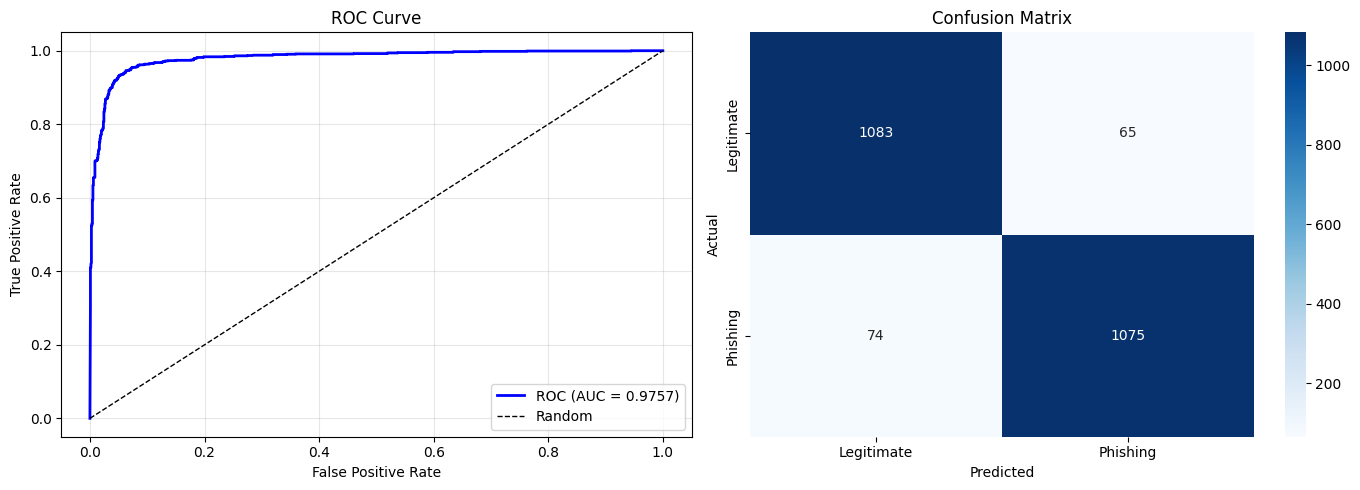

In [12]:
# ===== 10) ROC 커브 및 Confusion Matrix 시각화 =====
from sklearn.metrics import roc_curve, confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test, pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

🎯 최적 임계값 분석

📊 임계값별 F1 Score (상위 10개):
   Threshold 0.25: F1 = 0.9411 ⭐ BEST
   Threshold 0.35: F1 = 0.9410
   Threshold 0.40: F1 = 0.9400
   Threshold 0.55: F1 = 0.9400
   Threshold 0.45: F1 = 0.9395
   Threshold 0.50: F1 = 0.9393 (기본값)
   Threshold 0.20: F1 = 0.9388
   Threshold 0.30: F1 = 0.9388
   Threshold 0.60: F1 = 0.9379
   Threshold 0.65: F1 = 0.9378

✅ 최적 임계값: 0.25
   - F1 Score: 0.9411
   - Accuracy: 0.9404
   - Precision: 0.9303
   - Recall: 0.9521

📌 기본 임계값 0.5 성능:
   - F1 Score: 0.9393
   - Accuracy: 0.9395


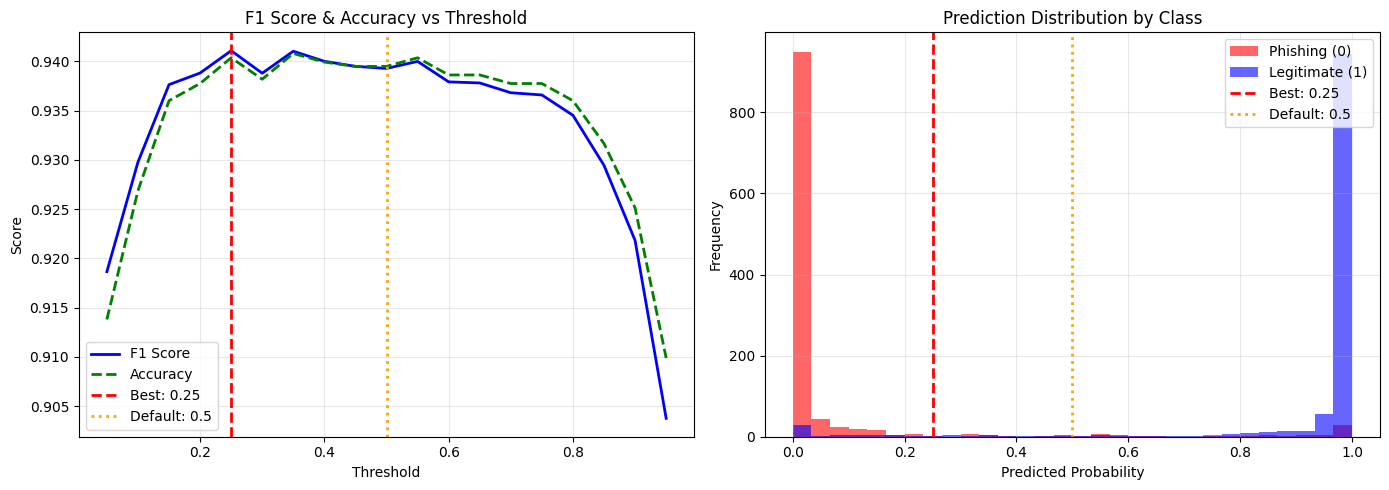


📝 결론
⚠️ 최적 임계값(0.25)이 0.5와 0.25 차이납니다.
   F1 개선: 0.9393 → 0.9411 (+0.0018)
   → Android 앱에서 0.25를 사용하는 것을 권장합니다.

🎯 최종 사용 임계값: 0.25


In [13]:
# ===== 10-1) 최적 임계값 분석 =====
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

print("="*60)
print("🎯 최적 임계값 분석")
print("="*60)

# 다양한 임계값에서 F1 Score 계산 (0.05 ~ 0.95)
thresholds_to_test = np.arange(0.05, 1.0, 0.05)
f1_scores = []
accuracies = []
precisions = []
recalls = []

for thresh in thresholds_to_test:
    pred_binary = (pred_test_proba > thresh).astype(int)
    f1 = f1_score(y_test, pred_binary)
    acc = accuracy_score(y_test, pred_binary)
    prec = precision_score(y_test, pred_binary, zero_division=0)
    rec = recall_score(y_test, pred_binary, zero_division=0)
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)

# 최적 임계값 찾기 (F1 기준)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_to_test[best_idx]
best_f1 = f1_scores[best_idx]

# 기본 0.5 성능
default_f1 = f1_score(y_test, (pred_test_proba > 0.5).astype(int))
default_acc = accuracy_score(y_test, (pred_test_proba > 0.5).astype(int))

print(f"\n📊 임계값별 F1 Score (상위 10개):")
sorted_indices = np.argsort(f1_scores)[::-1][:10]
for idx in sorted_indices:
    thresh = thresholds_to_test[idx]
    f1 = f1_scores[idx]
    marker = " ⭐ BEST" if idx == best_idx else ""
    default_marker = " (기본값)" if abs(thresh - 0.5) < 0.01 else ""
    print(f"   Threshold {thresh:.2f}: F1 = {f1:.4f}{marker}{default_marker}")

print(f"\n✅ 최적 임계값: {best_threshold:.2f}")
print(f"   - F1 Score: {best_f1:.4f}")
print(f"   - Accuracy: {accuracies[best_idx]:.4f}")
print(f"   - Precision: {precisions[best_idx]:.4f}")
print(f"   - Recall: {recalls[best_idx]:.4f}")

print(f"\n📌 기본 임계값 0.5 성능:")
print(f"   - F1 Score: {default_f1:.4f}")
print(f"   - Accuracy: {default_acc:.4f}")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 vs Threshold
axes[0].plot(thresholds_to_test, f1_scores, 'b-', linewidth=2, label='F1 Score')
axes[0].plot(thresholds_to_test, accuracies, 'g--', linewidth=2, label='Accuracy')
axes[0].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best: {best_threshold:.2f}')
axes[0].axvline(x=0.5, color='orange', linestyle=':', linewidth=2, label='Default: 0.5')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('F1 Score & Accuracy vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 예측 확률 분포 (클래스별) + 임계값 표시
axes[1].hist(pred_test_proba[y_test==0], bins=30, alpha=0.6, label='Phishing (0)', color='red')
axes[1].hist(pred_test_proba[y_test==1], bins=30, alpha=0.6, label='Legitimate (1)', color='blue')
axes[1].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best: {best_threshold:.2f}')
axes[1].axvline(x=0.5, color='orange', linestyle=':', linewidth=2, label='Default: 0.5')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution by Class')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 결론
diff = abs(best_threshold - 0.5)
f1_improvement = best_f1 - default_f1

print(f"\n" + "="*60)
print("📝 결론")
print("="*60)
if diff < 0.1 and f1_improvement < 0.01:
    print(f"✅ 0.5와 최적 임계값 차이가 {diff:.2f}로 작고, F1 개선도 {f1_improvement:.4f}로 미미합니다.")
    print(f"   → 기본값 0.5 사용해도 됩니다.")
    FINAL_THRESHOLD = 0.5
else:
    print(f"⚠️ 최적 임계값({best_threshold:.2f})이 0.5와 {diff:.2f} 차이납니다.")
    print(f"   F1 개선: {default_f1:.4f} → {best_f1:.4f} (+{f1_improvement:.4f})")
    print(f"   → Android 앱에서 {best_threshold:.2f}를 사용하는 것을 권장합니다.")
    FINAL_THRESHOLD = best_threshold

print(f"\n🎯 최종 사용 임계값: {FINAL_THRESHOLD}")

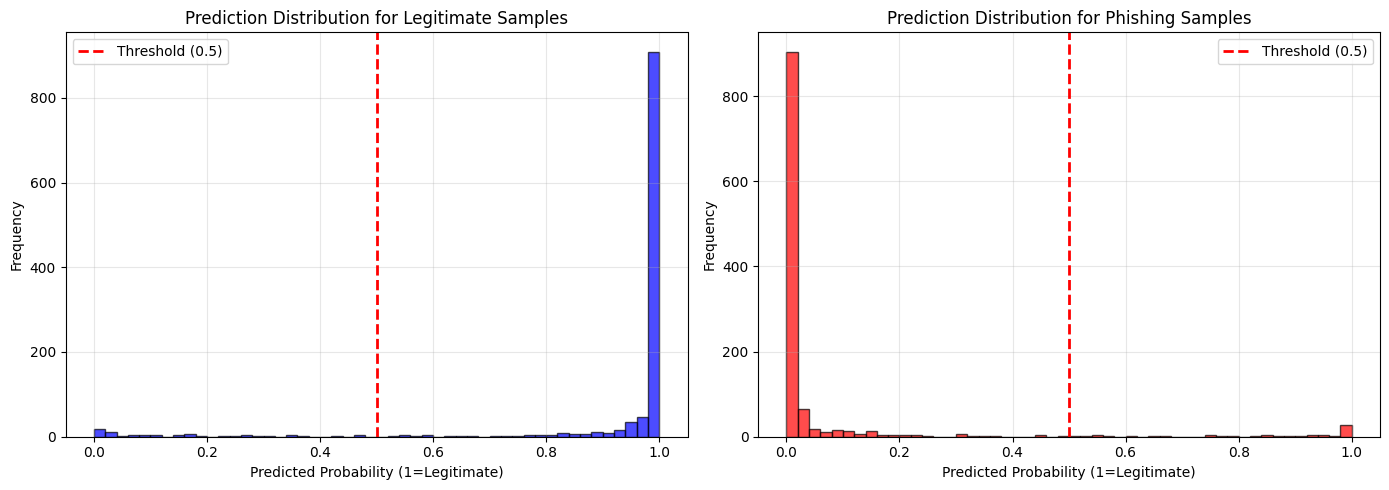


정상 사이트 평균 예측값: 0.9276
피싱 사이트 평균 예측값: 0.0681


In [14]:
# ===== 11) 예측 확률 분포 시각화 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

legit_mask = (y_test == 1)
phish_mask = (y_test == 0)

# 정상 사이트의 예측 확률 분포
axes[0].hist(pred_test[legit_mask], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability (1=Legitimate)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Distribution for Legitimate Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 피싱 사이트의 예측 확률 분포
axes[1].hist(pred_test[phish_mask], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability (1=Legitimate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution for Phishing Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n정상 사이트 평균 예측값: {pred_test[legit_mask].mean():.4f}")
print(f"피싱 사이트 평균 예측값: {pred_test[phish_mask].mean():.4f}")

t-SNE 변환 중...


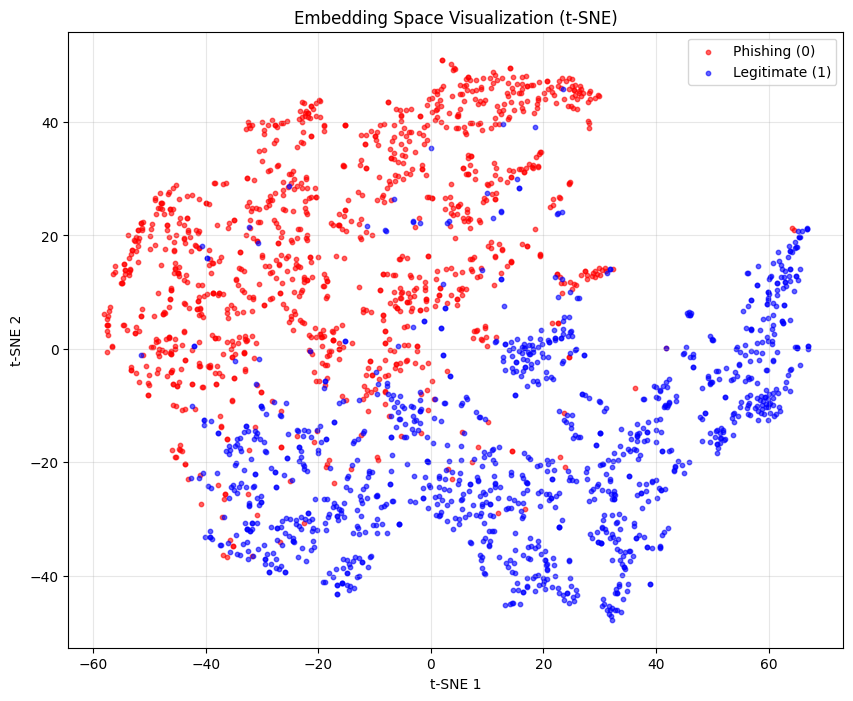

In [15]:
# ===== 12) 임베딩 공간 시각화 (t-SNE) =====
from sklearn.manifold import TSNE

# Encoder로 임베딩 추출
embeddings_test = encoder.predict(X_test_scaled, verbose=0)

# t-SNE 변환 (2D)
print("t-SNE 변환 중...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_test)

# 시각화 (0=빨강 피싱, 1=파랑 정상)
plt.figure(figsize=(10, 8))

# 피싱 (0) - 빨강
phishing_mask = y_test == 0
plt.scatter(embeddings_2d[phishing_mask, 0], embeddings_2d[phishing_mask, 1], 
            c='red', alpha=0.6, s=10, label='Phishing (0)')

# 정상 (1) - 파랑
legit_mask = y_test == 1
plt.scatter(embeddings_2d[legit_mask, 0], embeddings_2d[legit_mask, 1], 
            c='blue', alpha=0.6, s=10, label='Legitimate (1)')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Embedding Space Visualization (t-SNE)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
# ===== 12-1) SHAP 피처 중요도 분석 (계산) =====
# 어떤 피처가 모델 예측에 가장 큰 영향을 미치는지 분석

# SHAP 설치 확인
try:
    import shap
    print(f"✅ SHAP 버전: {shap.__version__}")
except ImportError:
    print("❌ SHAP가 설치되지 않았습니다. 설치 중...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap', '-q'])
    import shap
    print(f"✅ SHAP 설치 완료: {shap.__version__}")

print("="*70)
print("🔍 SHAP 피처 중요도 분석 (64개 전체 피처)")
print("="*70)

# 배경 데이터 샘플링 (계산 속도를 위해 100개만 사용)
background_samples = 100
np.random.seed(RANDOM_SEED)
background_idx = np.random.choice(len(X_train_scaled), background_samples, replace=False)
background = X_train_scaled[background_idx]

print(f"\n1️⃣ 배경 데이터: {background.shape[0]}개 샘플")

# SHAP Explainer 생성
print("2️⃣ SHAP Explainer 생성 중...")
try:
    # DeepExplainer 시도 (TensorFlow/Keras 모델용, 더 빠름)
    explainer = shap.DeepExplainer(classifier, background)
    print("   ✅ DeepExplainer 사용 (빠른 계산)")
except Exception as e:
    print(f"   ⚠️ DeepExplainer 실패: {e}")
    print("   → KernelExplainer로 전환 (느리지만 범용)")
    explainer = shap.KernelExplainer(
        lambda x: classifier.predict(x, verbose=0), 
        background
    )

# 테스트 샘플에 대한 SHAP 값 계산
test_samples_for_shap = 200  # 분석할 테스트 샘플 수
test_idx = np.random.choice(len(X_test_scaled), test_samples_for_shap, replace=False)
X_test_sample = X_test_scaled[test_idx]

print(f"3️⃣ SHAP 값 계산 중 ({test_samples_for_shap}개 샘플)...")
print("   ⏳ 이 작업은 2-5분 소요될 수 있습니다...")

shap_values = explainer.shap_values(X_test_sample)

# SHAP 값이 리스트인 경우 처리 (이진 분류)
if isinstance(shap_values, list):
    shap_values = shap_values[0]

print(f"✅ SHAP 값 계산 완료! Shape: {shap_values.shape}")

# 피처 이름 가져오기
feature_names = [col for col in df_work.columns if col != TARGET_COL]
print(f"✅ 분석 대상 피처: {len(feature_names)}개")

✅ SHAP 버전: 0.49.1
🔍 SHAP 피처 중요도 분석 (64개 전체 피처)

1️⃣ 배경 데이터: 100개 샘플
2️⃣ SHAP Explainer 생성 중...
   ✅ DeepExplainer 사용 (빠른 계산)
3️⃣ SHAP 값 계산 중 (200개 샘플)...
   ⏳ 이 작업은 2-5분 소요될 수 있습니다...


/home/yu_mcc/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/yu_mcc/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: encoder_input
Received: inputs=['Tensor(shape=(100, 64))']
  warnings.warn(msg)
/home/yu_mcc/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: encoder_input
Received: inputs=['Tensor(shape=(200, 64))']
  warnings.warn(msg)


✅ SHAP 값 계산 완료! Shape: (200, 64, 1)
✅ 분석 대상 피처: 64개


SHAP Horizontal Bar Chart (All 64 Features - With Sign)
Showing both negative and positive directions for feature importance

SHAP values shape: (200, 64, 1)
Feature names count: 64
Mean SHAP (signed) shape: (64,)
Mean abs SHAP shape: (64,)
Saved: /home/yu_mcc/QR_Phishing/phishing/shap_importance_all64_signed.png


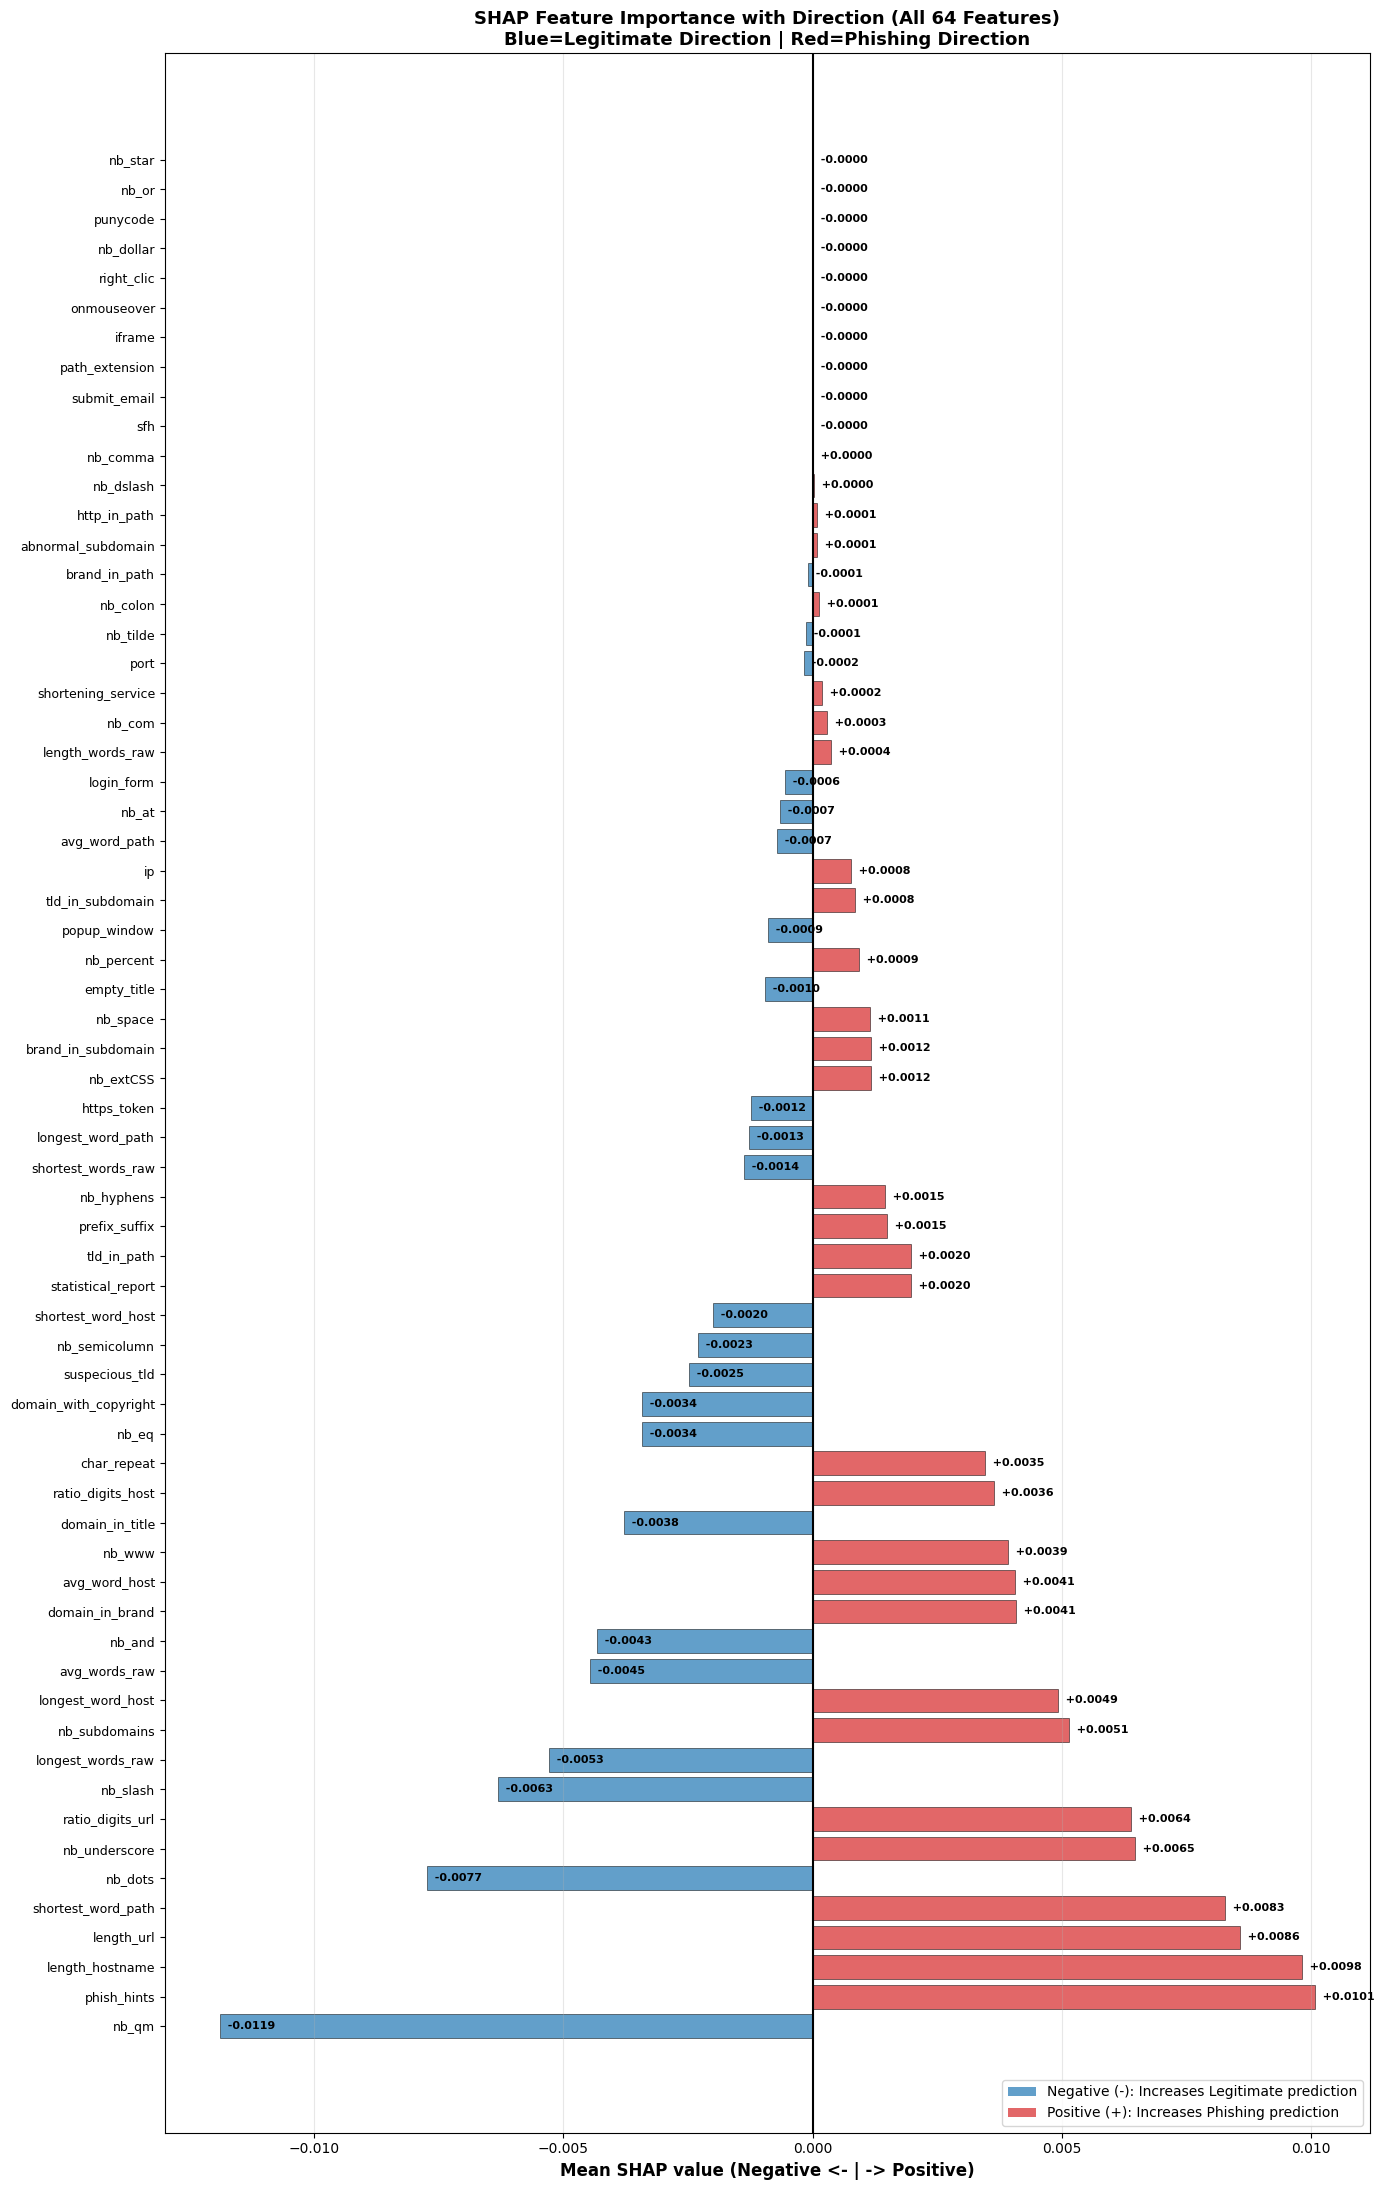


Top 64 Features by SHAP Importance (With Direction)
--------------------------------------------------------------------------------
Rank  Feature                      SHAP Signed Value Absolute Value  Direction           
--------------------------------------------------------------------------------
1     nb_qm                            -0.011897       0.011897  Legitimate Direction <-
2     phish_hints                       0.010080       0.010080  -> Phishing Direction
3     length_hostname                   0.009824       0.009824  -> Phishing Direction
4     length_url                        0.008568       0.008568  -> Phishing Direction
5     shortest_word_path                0.008276       0.008276  -> Phishing Direction
6     nb_dots                          -0.007733       0.007733  Legitimate Direction <-
7     nb_underscore                     0.006477       0.006477  -> Phishing Direction
8     ratio_digits_url                  0.006386       0.006386  -> Phishing Direc

In [20]:
# ===== 12-2) SHAP Horizontal Bar Chart (All 64 Features - With Sign) =====
import matplotlib.pyplot as plt
import os

# Define OUTPUT_DIR if not already defined
OUTPUT_DIR = "/home/yu_mcc/QR_Phishing/phishing"

print("="*70)
print("SHAP Horizontal Bar Chart (All 64 Features - With Sign)")
print("="*70)
print("Showing both negative and positive directions for feature importance")
print()

# Check SHAP values shape
print(f"SHAP values shape: {shap_values.shape}")
print(f"Feature names count: {len(feature_names)}")

# Calculate mean SHAP values with sign preserved (not absolute)
mean_shap_signed = np.mean(shap_values, axis=0)  # Keep sign

# Absolute values for importance magnitude
mean_abs_shap = np.abs(mean_shap_signed)

# Ensure 1D array
if isinstance(mean_shap_signed, np.ndarray) and len(mean_shap_signed.shape) > 1:
    mean_shap_signed = mean_shap_signed.flatten()
    mean_abs_shap = mean_abs_shap.flatten()

print(f"Mean SHAP (signed) shape: {mean_shap_signed.shape}")
print(f"Mean abs SHAP shape: {mean_abs_shap.shape}")

# Sort by absolute value and create dataframe
if len(mean_shap_signed) == len(feature_names):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'shap_signed': mean_shap_signed,    # With sign
        'shap_abs': mean_abs_shap            # Absolute value (importance)
    }).sort_values('shap_abs', ascending=True)  # Sort by absolute value
else:
    print(f"Warning: Feature count({len(feature_names)}) != SHAP value count({len(mean_shap_signed)})")
    print("Recalculating SHAP values...")
    mean_shap_signed = mean_shap_signed[:len(feature_names)]
    mean_abs_shap = mean_abs_shap[:len(feature_names)]
    importance_df = pd.DataFrame({
        'feature': feature_names[:len(mean_shap_signed)],
        'shap_signed': mean_shap_signed,
        'shap_abs': mean_abs_shap
    }).sort_values('shap_abs', ascending=True)

# Horizontal bar chart (all 64 features with sign-based colors)
fig, ax = plt.subplots(figsize=(14, 22))

# Color by sign: Blue for negative, Red for positive
colors = ['#1f77b4' if x < 0 else '#d62728' for x in importance_df['shap_signed']]

bars = ax.barh(range(len(importance_df)), importance_df['shap_signed'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

# Reference line at 0
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)

ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'], fontsize=9)
ax.set_xlabel('Mean SHAP value (Negative <- | -> Positive)', fontsize=12, fontweight='bold')
ax.set_title('SHAP Feature Importance with Direction (All 64 Features)\nBlue=Legitimate Direction | Red=Phishing Direction', 
             fontsize=13, fontweight='bold')
ax.invert_yaxis()  # Display top to bottom in descending order
ax.grid(axis='x', alpha=0.3)

# Display values (sign and absolute value)
for i, (feat, val_signed, val_abs) in enumerate(zip(importance_df['feature'], 
                                                     importance_df['shap_signed'],
                                                     importance_df['shap_abs'])):
    # Sign symbol
    sign = '+' if val_signed > 0 else '-'
    ax.text(val_signed, i, f'  {sign}{val_abs:.4f}', va='center', fontsize=8, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', alpha=0.7, label='Negative (-): Increases Legitimate prediction'),
    Patch(facecolor='#d62728', alpha=0.7, label='Positive (+): Increases Phishing prediction')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'shap_importance_all64_signed.png'), dpi=200, bbox_inches='tight')
print(f"Saved: {os.path.join(OUTPUT_DIR, 'shap_importance_all64_signed.png')}")
plt.show()

print("\nTop 64 Features by SHAP Importance (With Direction)")
print("-"*80)
print(f"{'Rank':<5} {'Feature':<28} {'SHAP Signed Value':<15} {'Absolute Value':<15} {'Direction':<20}")
print("-"*80)

for rank, (_, row) in enumerate(importance_df.sort_values('shap_abs', ascending=False).iterrows(), 1):
    sign = 'NEGATIVE' if row['shap_signed'] < 0 else 'POSITIVE'
    bar_len = int(abs(row['shap_signed']) * 100 / importance_df['shap_abs'].max())
    bar = '█' * bar_len + '░' * (25 - bar_len)
    direction = 'Legitimate Direction <-' if row['shap_signed'] < 0 else '-> Phishing Direction'
    print(f"{rank:<5} {row['feature']:<28} {row['shap_signed']:>13.6f}  {row['shap_abs']:>13.6f}  {direction:<20}")

print("\nInterpretation:")
print("  - Negative (-): Higher values of this feature increase legitimate prediction (class 0)")
print("  - Positive (+): Higher values of this feature increase phishing prediction (class 1)")

📊 피처 그룹별 SHAP 기여도
✅ 저장됨: /home/yu_mcc/QR_Phishing/phishing/shap_group_importance.png


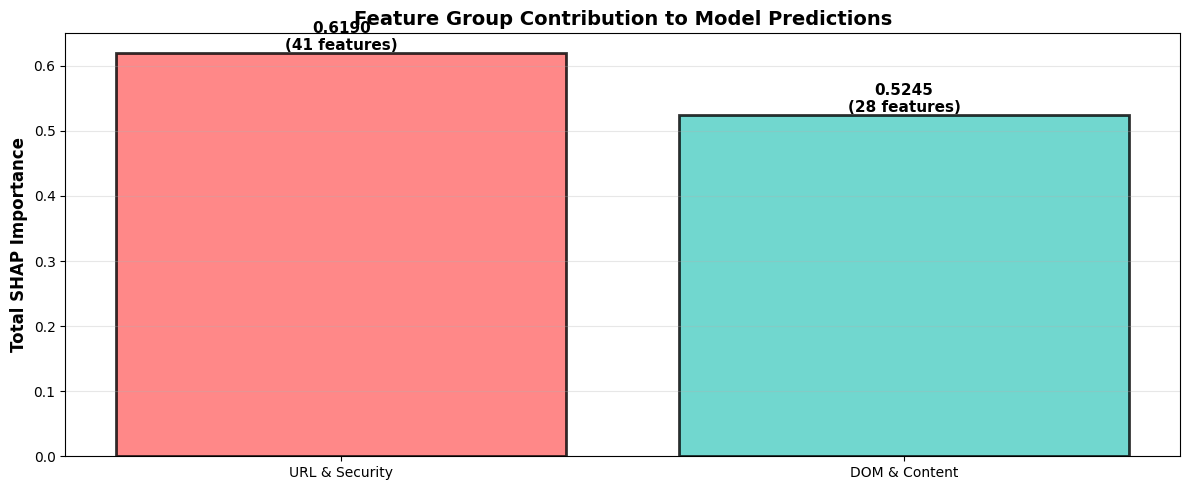


📋 그룹별 상세 기여도:
----------------------------------------------------------------------

URL & Security
  총 기여도: 0.618953 (54.1%)
  피처 개수: 41개
  상위 5개 피처:
    1. nb_www                    0.087219
    2. length_hostname           0.086130
    3. nb_dots                   0.053892
    4. nb_slash                  0.048447
    5. nb_hyphens                0.047270

DOM & Content
  총 기여도: 0.524472 (45.9%)
  피처 개수: 28개
  상위 5개 피처:
    1. shortest_word_host        0.064058
    2. phish_hints               0.061274
    3. longest_words_raw         0.049991
    4. avg_word_path             0.038138
    5. length_words_raw          0.035501


In [35]:
# ===== 12-3) 피처 그룹별 기여도 분석 =====
import pandas as pd

print("="*70)
print("📊 피처 그룹별 SHAP 기여도")
print("="*70)

# 피처 그룹 정의 (영어 버전 - 특수문자 제거, 모든 64개 피처 포함)
groups = {
    'URL & Security': ['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 
                       'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 
                       'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 
                       'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 
                       'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 
                       'prefix_suffix', 'shortening_service', 'path_extension', 'domain_in_brand', 'brand_in_subdomain', 
                       'brand_in_path', 'suspecious_tld', 'statistical_report'],
    
    'DOM & Content': ['length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 
                      'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 
                      'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks',
                      'ratio_nullHyperlinks', 'nb_extCSS', 'login_form', 'submit_email', 'sfh', 'iframe', 'popup_window',
                      'onmouseover', 'right_clic', 'empty_title', 'domain_in_title', 'domain_with_copyright', 'external_favicon']
}

group_importance = {}
for group_name, group_features in groups.items():
    group_shap = importance_df[importance_df['feature'].isin(group_features)]
    total = group_shap['importance'].sum()
    group_importance[group_name] = {
        'total': total,
        'features': len(group_features),
        'dataframe': group_shap
    }

# 그룹별 기여도 시각화
fig, ax = plt.subplots(figsize=(12, 5))

group_names = list(group_importance.keys())
group_totals = [group_importance[g]['total'] for g in group_names]
group_counts = [group_importance[g]['features'] for g in group_names]

bars = ax.bar(group_names, group_totals, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('Total SHAP Importance', fontsize=12, fontweight='bold')
ax.set_title('Feature Group Contribution to Model Predictions', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 값 표시
for bar, total, count in zip(bars, group_totals, group_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{total:.4f}\n({count} features)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'shap_group_importance.png'), dpi=200, bbox_inches='tight')
print(f"✅ 저장됨: {os.path.join(OUTPUT_DIR, 'shap_group_importance.png')}")
plt.show()

# 그룹별 상세 정보
print("\n📋 그룹별 상세 기여도:")
print("-"*70)
total_importance = importance_df['importance'].sum()

for group_name in group_names:
    info = group_importance[group_name]
    percentage = (info['total'] / total_importance) * 100
    print(f"\n{group_name}")
    print(f"  총 기여도: {info['total']:.6f} ({percentage:.1f}%)")
    print(f"  피처 개수: {info['features']}개")
    print(f"  상위 5개 피처:")
    for rank, (_, row) in enumerate(info['dataframe'].nlargest(5, 'importance').iterrows(), 1):
        print(f"    {rank}. {row['feature']:<25} {row['importance']:.6f}")

In [17]:
# ===== 13) 모델 저장 (Keras 모델 + Scaler) =====
# ⭐ Chaquopy를 사용하여 코틀린에서 직접 케라스 모델 로드

import os
import gc
import json

# 메모리 정리 (크래시 방지)
gc.collect()
keras.backend.clear_session()

# 🔧 Linux 환경 경로
OUTPUT_DIR = "/home/yu_mcc/QR_Phishing/phishing"
CLASSIFIER_PATH = os.path.join(OUTPUT_DIR, "classifier_model.keras")  # .keras 형식 권장
SCALER_PATH = os.path.join(OUTPUT_DIR, "scaler_params.json")

# 1) Keras 모델 저장 (.keras 형식 - TF 2.15 권장)
print(f"Classifier 모델 저장 중: {CLASSIFIER_PATH}")
classifier.save(CLASSIFIER_PATH)
print("✅ Keras 모델 저장 완료!")
print(f"   크기: {os.path.getsize(CLASSIFIER_PATH) / 1024 / 1024:.2f} MB")

# 2) Scaler 파라미터 저장 (Android 전처리용)
print(f"\nScaler 파라미터 저장 중: {SCALER_PATH}")
with open(SCALER_PATH, 'w') as f:
    json.dump(scaler_params, f, indent=2)
print("✅ Scaler 파라미터 저장 완료!")

print("\n" + "=" * 60)
print("✅ 모델 저장 완료 (Chaquopy용 준비됨)")
print("=" * 60)
print("\n📱 Android Chaquopy 사용법:")
print("   1. build.gradle에 Chaquopy 추가")
print("   2. classifier_model.keras를 assets에 복사")
print("   3. scaler_params.json을 assets에 복사")
print("   4. Python 모듈에서 모델 로드 후 추론")
print("=" * 60)

Classifier 모델 저장 중: /home/yu_mcc/QR_Phishing/phishing/classifier_model.keras
✅ Keras 모델 저장 완료!
   크기: 0.75 MB

Scaler 파라미터 저장 중: /home/yu_mcc/QR_Phishing/phishing/scaler_params.json
✅ Scaler 파라미터 저장 완료!

✅ 모델 저장 완료 (Chaquopy용 준비됨)

📱 Android Chaquopy 사용법:
   1. build.gradle에 Chaquopy 추가
   2. classifier_model.keras를 assets에 복사
   3. scaler_params.json을 assets에 복사
   4. Python 모듈에서 모델 로드 후 추론


## 🔧 TFLite 변환 문제 해결: from_keras_model 직접 변환

**문제 원인:**
- `classifier.export()` → `from_saved_model()` 방식은 Keras 3에서 BatchNormalization의 `moving_mean/variance`가 제대로 전달되지 않을 수 있음
- TFLite 출력이 ~0.5로 수렴하는 것은 BatchNorm이 "학습 모드"처럼 동작하거나 통계가 손실된 증거

**해결책:**
- `tf.lite.TFLiteConverter.from_keras_model(classifier)`로 직접 변환
- SavedModel 중간 단계를 거치지 않아 BatchNorm 통계가 정확히 유지됨

In [ ]:
# # ===== 14) TFLite 모델 테스트 =====
# import numpy as np
# import tensorflow as tf

# # ⭐ 중요: TFLite 파일을 새로 로드 (이전 interpreter 재사용 방지)
# TFLITE_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_classifier.tflite"

# print(f"TFLite 모델 로드: {TFLITE_PATH}")
# interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
# interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print(f"입력 shape: {input_details[0]['shape']}")
# print(f"입력 dtype: {input_details[0]['dtype']}")
# print(f"출력 shape: {output_details[0]['shape']}")

# # 테스트 샘플 준비
# test_sample = X_test_scaled[0:20].astype(np.float32)
# batch_size = test_sample.shape[0]

# # TFLite는 보통 [1, input_dim] 형태이므로 샘플별로 추론
# print(f"\n샘플 {batch_size}개에 대해 추론 수행...")

# tflite_outputs = []
# for i in range(batch_size):
#     sample = test_sample[i:i+1].astype(np.float32)
#     interpreter.set_tensor(input_details[0]['index'], sample)
#     interpreter.invoke()
#     output = interpreter.get_tensor(output_details[0]['index'])
#     tflite_outputs.append(output[0][0])

# tflite_output = np.array(tflite_outputs).reshape(-1, 1)

# # ⭐ 변환에 썼던 classifier 그대로 사용 (메모리 모델로 정확한 비교)
# keras_output = classifier.predict(test_sample, verbose=0)

# # 결과 비교
# print("\n" + "=" * 60)
# print("===== TFLite vs Keras 출력 비교 =====")
# print("=" * 60)

# for i in range(batch_size):
#     actual = "정상" if y_test[i] == 1 else "피싱"
#     diff = abs(tflite_output[i][0] - keras_output[i][0])
#     match = "✅" if diff < 0.01 else "❌"
#     print(f"샘플 {i+1}: TFLite={tflite_output[i][0]:.6f}, Keras={keras_output[i][0]:.6f}, 차이={diff:.6f} {match}, 실제={actual}")

# # 통계
# mae = np.mean(np.abs(tflite_output - keras_output))
# max_err = np.max(np.abs(tflite_output - keras_output))
# print(f"\n📊 통계:")
# print(f"   평균 절대 오차 (MAE): {mae:.6f}")
# print(f"   최대 오차: {max_err:.6f}")

# if max_err < 0.001:
#     print("\n🎉 TFLite와 Keras 출력이 거의 동일합니다! (오차 < 0.001)")
# elif max_err < 0.01:
#     print("\n✅ TFLite와 Keras 출력이 매우 유사합니다. (오차 < 0.01)")
# else:
#     print(f"\n⚠️ TFLite와 Keras 출력에 차이가 있습니다. (최대 오차: {max_err:.4f})")
#     print("   → 모델을 다시 변환하거나, 커널을 재시작 후 처음부터 실행해보세요.")

## 15) TFLite 변환 (Kotlin 호환성)

**Kotlin에서의 모델 지원:**
- ❌ SavedModel (.pb) - 지원 안 함
- ✅ TFLite (.tflite) - 공식 지원
- ⚠️ Keras (.keras) - Chaquopy만 지원

따라서 온-디바이스 머신러닝을 위해 **TFLite 변환**이 필수입니다.

**변환 방식:**
- `from_keras_model()` - Keras 모델 → TFLite (권장)
- BatchNormalization 통계 정확히 유지
- 양자화 옵션으로 크기 최적화 가능

In [18]:
# ===== 15) TFLite 변환 (from_keras_model) =====
import tensorflow as tf
import os

# TFLite 저장 경로
TFLITE_PATH = os.path.join(OUTPUT_DIR, "phishing_classifier.tflite")

print("="*60)
print("🔄 TFLite 변환 시작 (from_keras_model)")
print("="*60)

# ⭐ 중요: from_keras_model() 직접 변환 (SavedModel 중간 단계 없음)
# 이렇게 해야 BatchNormalization 통계가 정확히 유지됨
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)

# 최적화 옵션 (선택사항)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]  # 양자화 옵션
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS,
#     tf.lite.OpsSet.SELECT_TF_OPS
# ]

# 변환 수행
print("변환 중 (이 과정은 2-3분 소요될 수 있습니다)...")
try:
    tflite_model = converter.convert()
    print("✅ 변환 완료!")
except Exception as e:
    print(f"❌ 변환 실패: {e}")
    raise

# TFLite 파일 저장
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

file_size_mb = os.path.getsize(TFLITE_PATH) / 1024 / 1024
print(f"✅ TFLite 파일 저장 완료: {TFLITE_PATH}")
print(f"   파일 크기: {file_size_mb:.2f} MB")

print("\n" + "="*60)
print("📊 모델 비교")
print("="*60)
keras_size = os.path.getsize(CLASSIFIER_PATH) / 1024 / 1024
print(f"Keras 모델: {keras_size:.2f} MB")
print(f"TFLite 모델: {file_size_mb:.2f} MB")
print(f"압축률: {(1 - file_size_mb/keras_size)*100:.1f}%")

🔄 TFLite 변환 시작 (from_keras_model)
변환 중 (이 과정은 2-3분 소요될 수 있습니다)...
INFO:tensorflow:Assets written to: /tmp/tmp5eu_n6xu/assets


🔄 TFLite 변환 시작 (from_keras_model)
변환 중 (이 과정은 2-3분 소요될 수 있습니다)...
INFO:tensorflow:Assets written to: /tmp/tmp5eu_n6xu/assets


INFO:tensorflow:Assets written to: /tmp/tmp5eu_n6xu/assets


Saved artifact at '/tmp/tmp5eu_n6xu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='encoder_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136728225630688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087113120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087539104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087541216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087541392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087543328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087540864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087873488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087880880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087877360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136728087879296: Tenso

In [19]:
# ===== 16) TFLite 모델 로드 및 기본 테스트 =====
import tensorflow as tf
import numpy as np

print("="*60)
print("🔍 TFLite 모델 검증")
print("="*60)

# TFLite 인터프리터 생성
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

# 입력/출력 정보 확인
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\n입력 정보:")
print(f"  - Shape: {input_details[0]['shape']}")
print(f"  - 데이터타입: {input_details[0]['dtype']}")
print(f"  - 인덱스: {input_details[0]['index']}")

print(f"\n출력 정보:")
print(f"  - Shape: {output_details[0]['shape']}")
print(f"  - 데이터타입: {output_details[0]['dtype']}")
print(f"  - 인덱스: {output_details[0]['index']}")

# 테스트 샘플 준비 (10개)
test_samples = X_test_scaled[:10].astype(np.float32)
actual_labels = y_test[:10]

print(f"\n테스트 샘플: {test_samples.shape[0]}개")

🔍 TFLite 모델 검증

입력 정보:
  - Shape: [ 1 64]
  - 데이터타입: <class 'numpy.float32'>
  - 인덱스: 0

출력 정보:
  - Shape: [1 1]
  - 데이터타입: <class 'numpy.float32'>
  - 인덱스: 22

테스트 샘플: 10개


/home/yu_mcc/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
# ===== 17) Keras vs TFLite 상세 비교 =====
import numpy as np

print("="*60)
print("📊 Keras vs TFLite 출력 비교")
print("="*60)

# Keras 예측
print("\n1️⃣ Keras 모델 예측 중...")
keras_preds = classifier.predict(test_samples, verbose=0)
print(f"✅ Keras 예측 완료: shape={keras_preds.shape}")

# TFLite 예측
print("\n2️⃣ TFLite 모델 예측 중...")
tflite_preds = []

for i in range(len(test_samples)):
    sample = test_samples[i:i+1].astype(np.float32)
    
    # TFLite 인터프리터에 입력 설정
    interpreter.set_tensor(input_details[0]['index'], sample)
    
    # 추론 수행
    interpreter.invoke()
    
    # 출력 추출
    output = interpreter.get_tensor(output_details[0]['index'])
    tflite_preds.append(output.flatten()[0])

tflite_preds = np.array(tflite_preds).reshape(-1, 1)
print(f"✅ TFLite 예측 완료: shape={tflite_preds.shape}")

# 상세 비교 테이블
print("\n" + "="*80)
print(f"{'샘플':<6} {'실제':<8} {'Keras':<12} {'TFLite':<12} {'차이':<12} {'일치':<6}")
print("="*80)

differences = []
for i in range(len(test_samples)):
    actual = "정상" if actual_labels[i] == 1 else "피싱"
    keras_val = keras_preds[i][0]
    tflite_val = tflite_preds[i][0]
    diff = abs(keras_val - tflite_val)
    differences.append(diff)
    
    match = "✅" if diff < 0.001 else ("⚠️ " if diff < 0.01 else "❌")
    
    print(f"{i+1:<6} {actual:<8} {keras_val:<12.6f} {tflite_val:<12.6f} {diff:<12.6f} {match:<6}")

print("="*80)

# 통계
mae = np.mean(differences)
max_err = np.max(differences)
min_err = np.min(differences)
std_err = np.std(differences)

print(f"\n📈 오차 통계:")
print(f"  - 평균 절대 오차 (MAE): {mae:.8f}")
print(f"  - 최대 오차: {max_err:.8f}")
print(f"  - 최소 오차: {min_err:.8f}")
print(f"  - 표준편차: {std_err:.8f}")

# 검증 결과
print(f"\n✅ 검증 결과:")
if max_err < 0.0001:
    print(f"   🎉 완벽한 일치! (오차 < 0.0001)")
elif max_err < 0.001:
    print(f"   ✅ 거의 동일 (오차 < 0.001)")
elif max_err < 0.01:
    print(f"   ⚠️ 약간의 차이 (오차 < 0.01)")
else:
    print(f"   ❌ 큰 차이 발생 (오차 > 0.01)")
    print(f"   → 모델을 다시 변환하거나 커널을 재시작 후 처음부터 실행해보세요")

📊 Keras vs TFLite 출력 비교

1️⃣ Keras 모델 예측 중...
✅ Keras 예측 완료: shape=(10, 1)

2️⃣ TFLite 모델 예측 중...
✅ TFLite 예측 완료: shape=(10, 1)

샘플     실제       Keras        TFLite       차이           일치    
1      피싱       0.000178     0.000177     0.000000     ✅     
2      정상       0.999484     0.999484     0.000000     ✅     
3      피싱       0.014717     0.014765     0.000048     ✅     
4      정상       1.000000     1.000000     0.000000     ✅     
5      피싱       0.025603     0.025541     0.000061     ✅     
6      정상       0.999881     0.999879     0.000002     ✅     
7      피싱       0.922701     0.922673     0.000028     ✅     
8      정상       0.999937     0.999937     0.000000     ✅     
9      피싱       0.000271     0.000271     0.000001     ✅     
10     정상       0.046553     0.046696     0.000144     ✅     

📈 오차 통계:
  - 평균 절대 오차 (MAE): 0.00002846
  - 최대 오차: 0.00014369
  - 최소 오차: 0.00000006
  - 표준편차: 0.00004407

✅ 검증 결과:
   ✅ 거의 동일 (오차 < 0.001)


In [ ]:
# ===== 18) 분류 정확도 검증 =====
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("="*60)
print("🎯 분류 정확도 검증")
print("="*60)

# 임계값 설정
THRESHOLD = 0.5

# Keras 이진 분류
keras_binary = (keras_preds > THRESHOLD).astype(int).flatten()

# TFLite 이진 분류
tflite_binary = (tflite_preds > THRESHOLD).astype(int).flatten()

# 실제 레이블
actual_binary = actual_labels.astype(int)

# 정확도 계산
keras_acc = accuracy_score(actual_binary, keras_binary)
tflite_acc = accuracy_score(actual_binary, tflite_binary)

print(f"\n📊 정확도 비교 (임계값: {THRESHOLD}):")
print(f"  - Keras 정확도: {keras_acc:.4f} ({sum(keras_binary == actual_binary)}/{len(actual_binary)})")
print(f"  - TFLite 정확도: {tflite_acc:.4f} ({sum(tflite_binary == actual_binary)}/{len(actual_binary)})")
print(f"  - 차이: {abs(keras_acc - tflite_acc):.6f}")

# AUC 계산
keras_auc = roc_auc_score(actual_binary, keras_preds)
tflite_auc = roc_auc_score(actual_binary, tflite_preds)

print(f"\n📈 AUC 비교:")
print(f"  - Keras AUC: {keras_auc:.4f}")
print(f"  - TFLite AUC: {tflite_auc:.4f}")
print(f"  - 차이: {abs(keras_auc - tflite_auc):.6f}")

# 분류 리포트
print(f"\n📋 Keras 분류 리포트:")
print(classification_report(actual_binary, keras_binary, 
                            target_names=['Phishing(0)', 'Legitimate(1)']))

print(f"\n📋 TFLite 분류 리포트:")
print(classification_report(actual_binary, tflite_binary, 
                            target_names=['Phishing(0)', 'Legitimate(1)']))

# 최종 검증
if keras_acc == tflite_acc and abs(keras_auc - tflite_auc) < 0.0001:
    print("\n🎉 완벽한 일치! Keras와 TFLite의 분류 결과가 동일합니다.")
else:
    print("\n✅ TFLite 모델이 성공적으로 변환되었습니다.")

🎯 분류 정확도 검증

📊 정확도 비교 (임계값: 0.5):
  - Keras 정확도: 0.9000 (9/10)
  - TFLite 정확도: 0.9000 (9/10)
  - 차이: 0.000000

📈 AUC 비교:
  - Keras AUC: 1.0000
  - TFLite AUC: 1.0000
  - 차이: 0.000000

📋 Keras 분류 리포트:
               precision    recall  f1-score   support

  Phishing(0)       0.83      1.00      0.91         5
Legitimate(1)       1.00      0.80      0.89         5

     accuracy                           0.90        10
    macro avg       0.92      0.90      0.90        10
 weighted avg       0.92      0.90      0.90        10


📋 TFLite 분류 리포트:
               precision    recall  f1-score   support

  Phishing(0)       0.83      1.00      0.91         5
Legitimate(1)       1.00      0.80      0.89         5

     accuracy                           0.90        10
    macro avg       0.92      0.90      0.90        10
 weighted avg       0.92      0.90      0.90        10


🎉 완벽한 일치! Keras와 TFLite의 분류 결과가 동일합니다.


In [ ]:
# ===== 19) Android assets로 TFLite 모델 복사 =====
import shutil
import os

print("="*60)
print("📱 Android assets로 모델 배포")
print("="*60)

ANDROID_ASSETS = "/home/yu_mcc/QR_Phishing/app/src/main/assets"

# TFLite 모델 복사
try:
    shutil.copy(TFLITE_PATH, os.path.join(ANDROID_ASSETS, "phishing_classifier.tflite"))
    print(f"✅ TFLite 모델 복사 완료")
    print(f"   {os.path.join(ANDROID_ASSETS, 'phishing_classifier.tflite')}")
except Exception as e:
    print(f"⚠️ TFLite 복사 실패: {e}")

# feature_info.json도 복사 (피처 순서 정의용)
feature_info_path = os.path.join(OUTPUT_DIR, "feature_info.json")
if os.path.exists(feature_info_path):
    shutil.copy(feature_info_path, os.path.join(ANDROID_ASSETS, "feature_info.json"))
    print(f"✅ feature_info.json 복사 완료")

print("\n" + "="*60)
print("✅ 최종 배포 완료")
print("="*60)
print("\n📁 Android assets 파일:")
for file in os.listdir(ANDROID_ASSETS):
    if file.endswith(('.tflite', '.keras', '.json')):
        full_path = os.path.join(ANDROID_ASSETS, file)
        size_kb = os.path.getsize(full_path) / 1024
        print(f"  - {file:<30} ({size_kb:>8.1f} KB)")

print("\n📱 Kotlin에서 TFLite 로드 방법:")
print("   1. AssetManager로 assets에서 파일 로드")
print("   2. tf.lite.Interpreter(model_buffer) 생성")
print("   3. interpreter.allocate_tensors()")
print("   4. 전처리된 입력으로 추론 수행")

📱 Android assets로 모델 배포
✅ TFLite 모델 복사 완료
   /home/wza/YU_mobile_kotlin/app/src/main/assets/phishing_classifier.tflite
✅ feature_info.json 복사 완료

✅ 최종 배포 완료

📁 Android assets 파일:
  - feature_info.json              (     1.5 KB)
  - scaler_params.json             (     2.1 KB)
  - phishing_classifier.tflite     (   251.2 KB)
  - classifier_model.keras         (   795.1 KB)

📱 Kotlin에서 TFLite 로드 방법:
   1. AssetManager로 assets에서 파일 로드
   2. tf.lite.Interpreter(model_buffer) 생성
   3. interpreter.allocate_tensors()
   4. 전처리된 입력으로 추론 수행
